# Python Example 2: Lower crustal anisotropy

In this example we generate P receiver functions for a model that includes a lower-crustal anisotropic layer. This example follows that of Figure 2 in Porter et al. (2011). 

Start by importing the necessary modules

In [1]:
import numpy as np
from obspy.core import Stream
from obspy.signal.rotate import rotate_ne_rt
from telewavesim import green as gp
from telewavesim import utils as ut
from telewavesim import wiggle as wg
from telewavesim import conf as cf

/Users/pascalaudet/anaconda3/envs/tws-dev/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


Select the model file:

In [2]:
modfile = '../../models/model_Porter2011.txt'

Select the type of incident wave - options are 'P', 'SV', 'SH', or 'Si', which is an isotropic S-wave source

In [3]:
cf.wvtype = 'P'

Next we use global variables to define the desired time series

In [4]:
cf.nt = 3000 # Number of samples
cf.dt = 0.01 # sampling rate in seconds

Now specify the parameters of the incident wavefield in terms of a horizontal slowness and back-azimuth. In this example the slowness won't change, so we can pass it as a global variable now. The back-azimuth will range from 0 to 360 degrees with a 10-degree increment, so we define a `np.ndarray` for this variable and do not yet pass it as a global variable.

In [5]:
cf.slow = 0.06 # Horizontal slowness (or ray parameter) in s/km 
baz = np.arange(0., 360., 10.)

Read the model parameters from the model file and set global variables (hidden in the function). Up to here, the steps could have been performed in no particular order, except the name of the file that needs to be defined before the call to `read_model()`

In [6]:
ut.read_model(modfile)

As we need to loop through back-azimuth values, we will initialize empty `Stream` objects to store the traces from the output of the main routine. 

In [7]:
trR = Stream(); trT = Stream()

Now the main loop over back-azimuths where all calculations are done - self explanatory

In [8]:
# Loop over range of data 
for bb in baz:

    # Pass baz global variable
    cf.baz = bb

    # Calculate the Green's functions
    trxyz = gp.green_land()

    # Then the transfer functions in Z-R-T coordinate system
    tfs = gp.tf_from_xyz(trxyz,pvh=False)

    # Append to streams
    trR.append(tfs[0]); trT.append(tfs[1])


The result of the previous loop is a set of transfer functions. To get receiver functions, we simply filter the `Stream` objects using some frequency corners

In [9]:
# Set frequency corners in Hz
f1 = 0.01
f2 = 1.0

# Filter to get wave-like traces
trR.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)
trT.filter('bandpass',freqmin=f1, freqmax=f2, corners=2, zerophase=True)

36 Trace(s) in Stream:

... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:29.990000Z | 100.0 Hz, 3000 samples
...
(34 other traces)
...
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:29.990000Z | 100.0 Hz, 3000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Now plot the result as wiggles, using the format displayed in the paper by Porter et al. (2011). We also need to define 'stacked traces' that represent the average of all recceiver functions to be displayed.


Stacking ALL traces in streams

Plotting Wiggles by baz


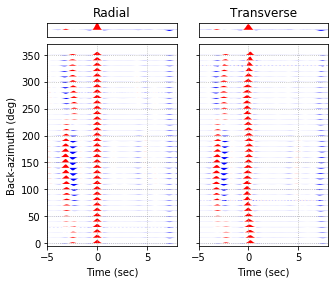

In [10]:
# Stack over all traces
trR_stack, trT_stack = ut.stack_all(trR, trT, pws=True)

# Plot as wiggles
wg.rf_wiggles_baz(trR, trT, trR_stack, trT_stack, 'test', btyp='baz', scale=1.e3, tmin=-5., tmax=8., save=False, title='_python')

And Voilà! 

Now try the same example but setting `cf.wvtype = 'SV'` to get S receiver functions for the same model. Such an example would correspond to a core-refracted shear wave (such as SKS) with no incident transverse component. In this case the receiver functions are unstable (spectral division by zero-valued SH component). Setting `cf.wvtype = 'Si'` will produce a transverse component receiver function, which is more realistic for incident S waves propagating through the mantle only. Be careful with the slowness values!!!